PARTE 1

In [1]:
import pandas as pd
import numpy as np

# 1. CARGA DE DATOS
ventas = pd.read_csv('transacciones_ventas.csv')
inventario = pd.read_csv('inventario_diario.csv')
maestro = pd.read_csv('maestro_productos.csv')

def clean_numeric(series):
    # Elimina ruido (símbolos, espacios) y convierte a numérico
    if series.dtype == 'O':
        return pd.to_numeric(series.astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')
    return pd.to_numeric(series, errors='coerce')

# 2. LIMPIEZA DE CATEGORÍAS Y TIPOS
for df in [ventas, inventario, maestro]:
    if 'categoria' in df.columns:
        df['categoria'] = df['categoria'].astype(str).str.strip().str.title()

# Conversión numérica de columnas críticas
cols_ventas = ['unidades_vendidas', 'precio_unitario_venta', 'precio_lista_original', 'costo_unitario']
for col in cols_ventas:
    ventas[col] = clean_numeric(ventas[col])

inventario['valor_inventario_costo'] = clean_numeric(inventario['valor_inventario_costo'])
maestro['costo_unitario'] = clean_numeric(maestro['costo_unitario'])
maestro['precio_lista'] = clean_numeric(maestro['precio_lista'])

# 3. INTEGRACIÓN CON MAESTRO DE PRODUCTOS
# Usamos el maestro para rellenar costos o precios de lista faltantes en ventas
ventas_full = ventas.merge(maestro[['product_id', 'costo_unitario', 'precio_lista']], 
                           on='product_id', how='left', suffixes=('_v', '_m'))

# Lógica de fallback
ventas_full['costo_final'] = ventas_full['costo_unitario_v'].fillna(ventas_full['costo_unitario_m'])
ventas_full['precio_lista_final'] = ventas_full['precio_lista_original'].fillna(ventas_full['precio_lista'])

# 4. CÁLCULO DE MÉTRICAS
ventas_full['utilidad_bruta'] = ventas_full['unidades_vendidas'] * (ventas_full['precio_unitario_venta'] - ventas_full['costo_final'])
ventas_full['ingreso_real'] = ventas_full['unidades_vendidas'] * ventas_full['precio_unitario_venta']
ventas_full['ingreso_potencial'] = ventas_full['unidades_vendidas'] * ventas_full['precio_lista_final']

# Agrupación por categoría (filtrando valores nulos de categoría)
ventas_full = ventas_full[ventas_full['categoria'] != 'Nan']
cat_stats = ventas_full.groupby('categoria').agg({
    'utilidad_bruta': 'sum',
    'ingreso_real': 'sum',
    'ingreso_potencial': 'sum'
}).reset_index()

# Inventario promedio a costo
cat_inv = inventario[inventario['categoria'] != 'Nan'].groupby('categoria')['valor_inventario_costo'].mean().reset_index()
cat_inv.columns = ['categoria', 'inv_promedio_costo']

# 5. RESULTADOS FINALES (GMROI y Markdown)
df_final = cat_stats.merge(cat_inv, on='categoria')
df_final['GMROI'] = df_final['utilidad_bruta'] / df_final['inv_promedio_costo']
df_final['Markdown_Pct'] = (1 - (df_final['ingreso_real'] / df_final['ingreso_potencial'])) * 100

print(df_final[['categoria', 'GMROI', 'Markdown_Pct']].sort_values(by='GMROI', ascending=False).head(10))

                      categoria      GMROI  Markdown_Pct
137                       Hogar  94.049948      6.983152
229                   Relojería  86.077190      4.746089
58                       Carnes  84.140954      5.391397
151                 Informática  81.553854      6.693066
196                     Muebles  81.403035      3.758732
240                 Ropa Hombre  80.933400      5.923863
86                     Deportes  80.854814      9.166626
20                   Automotriz  79.969620      5.207047
216  Pequeños Electrodomésticos  79.892662      4.808126
180                     Lácteos  79.524157      6.643881


PARTE 2

In [ ]:
import asyncio
from playwright.async_api import async_playwright
import statistics
import nest_asyncio

nest_asyncio.apply()

async def realizar_tarea_final():
    async def scrape_tipo(tipo):
        print(f"\n--- Extrayendo {tipo.upper()} en Huechuraba ---")
        results = []
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=False)
            page = await browser.new_page()
            url = f"https://www.portalinmobiliario.cl/venta/{tipo}/huechuraba-metropolitana"
            
            try:
                await page.goto(url, wait_until="domcontentloaded", timeout=60000)
                pagina = 1
                while True:
                    print(f"Procesando página {pagina}...")
                    await asyncio.sleep(2)
                    await page.mouse.wheel(0, 3000)
                    await asyncio.sleep(1)

                    items = await page.query_selector_all(".ui-search-result__wrapper")
                    for item in items:
                        try:
                            # 1. Obtener Precio
                            p_elem = await item.query_selector(".andes-money-amount__fraction")
                            # 2. Obtener Símbolo de moneda (UF vs $)
                            currency_elem = await item.query_selector(".andes-money-amount__currency-symbol")
                            currency = await currency_elem.inner_text() if currency_elem else ""
                            
                            card_text = await item.inner_text()
                            m2_val = None
                            if "m²" in card_text:
                                parts = card_text.split()
                                for i, part in enumerate(parts):
                                    if "m²" in part and i > 0:
                                        m2_val = float(parts[i-1].replace('.', '').replace(',', '.'))
                                        break
                            
                            if p_elem and m2_val and "UF" in currency:
                                price = float((await p_elem.inner_text()).replace('.', ''))
                                # Filtro de seguridad para evitar datos erróneos
                                if 1000 < price < 100000: 
                                    results.append({"p": price, "m": m2_val})
                        except: continue

                    # Lógica de paginación, para el navbar
                    next_btn = await page.query_selector('a[title="Siguiente"]')
                    if next_btn and await next_btn.is_visible():
                        await next_btn.click()
                        pagina += 1
                        await page.wait_for_load_state("domcontentloaded")
                    else:
                        break # Salir del bucle si no hay más páginas
                
            except Exception as e:
                print(f"Fin de navegación: {e}")
            finally:
                await browser.close()
        return results

    c_data = await scrape_tipo("casa")
    d_data = await scrape_tipo("departamento")

    def get_stats(lista):
        if not lista: return [0, 0, 0, 0]
        precios = [x['p'] for x in lista]
        uf_m2 = [x['p']/x['m'] for x in lista if x['m'] > 0]
        return [len(lista), statistics.median(precios), statistics.mean(precios), statistics.mean(uf_m2)]

    c, d = get_stats(c_data), get_stats(d_data)

    print("\n" + "="*65)
    print(f"{'Métrica':<35} | {'Casas':<12} | {'Deptos':<12}")
    print("-" * 65)
    print(f"{'Propiedades filtradas (#)':<35} | {c[0]:<12.0f} | {d[0]:<12.0f}")
    print(f"{'Mediana precio (UF)':<35} | {c[1]:<12.0f} | {d[1]:<12.0f}")
    print(f"{'Promedio precio (UF)':<35} | {c[2]:<12.0f} | {d[2]:<12.0f}")
    print(f"{'Precio por m2 (UF/m2)':<35} | {c[3]:<12.2f} | {d[3]:<12.2f}")
    print("="*65)

await realizar_tarea_final()


--- Extrayendo CASA en Huechuraba ---
Procesando página 1...
Procesando página 2...
Procesando página 3...
Procesando página 4...
Procesando página 5...
Procesando página 6...
Procesando página 7...
Procesando página 8...
Procesando página 9...
Procesando página 10...
Procesando página 11...
Procesando página 12...
Procesando página 13...
Procesando página 14...
Procesando página 15...

--- Extrayendo DEPARTAMENTO en Huechuraba ---
Procesando página 1...
Procesando página 2...
Procesando página 3...
Procesando página 4...
Procesando página 5...
Procesando página 6...
Procesando página 7...
Procesando página 8...
Procesando página 9...
Procesando página 10...
Procesando página 11...

Métrica                             | Casas        | Deptos      
-----------------------------------------------------------------
Propiedades filtradas (#)           | 670          | 489         
Mediana precio (UF)                 | 8570         | 5750        
Promedio precio (UF)                | 9776 

TERCERA PARTE

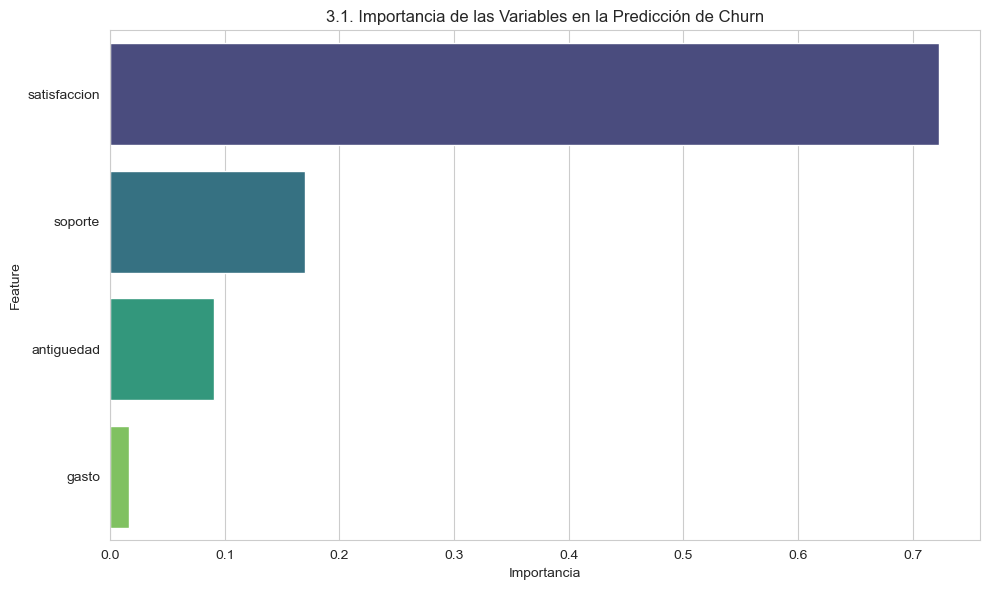

=== 3.1. REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     30034
           1       0.83      0.31      0.46      5066

    accuracy                           0.89     35100
   macro avg       0.86      0.65      0.70     35100
weighted avg       0.89      0.89      0.87     35100


=== 3.2. TABLA DE LIFT Y GANANCIA (10 DECILES) ===
       Clientes  Churners_Encontrados      Lift  Ganancia_Acumulada_%
Decil                                                                
1          3510                  2385  4.707856             47.078563
2          3510                  1505  2.970786             76.786419
3          3510                   577  1.138966             88.176076
4          3510                   236  0.465851             92.834583
5          3510                    59  0.116463             93.999210
6          3510                    58  0.114489             95.144098
7          3510        

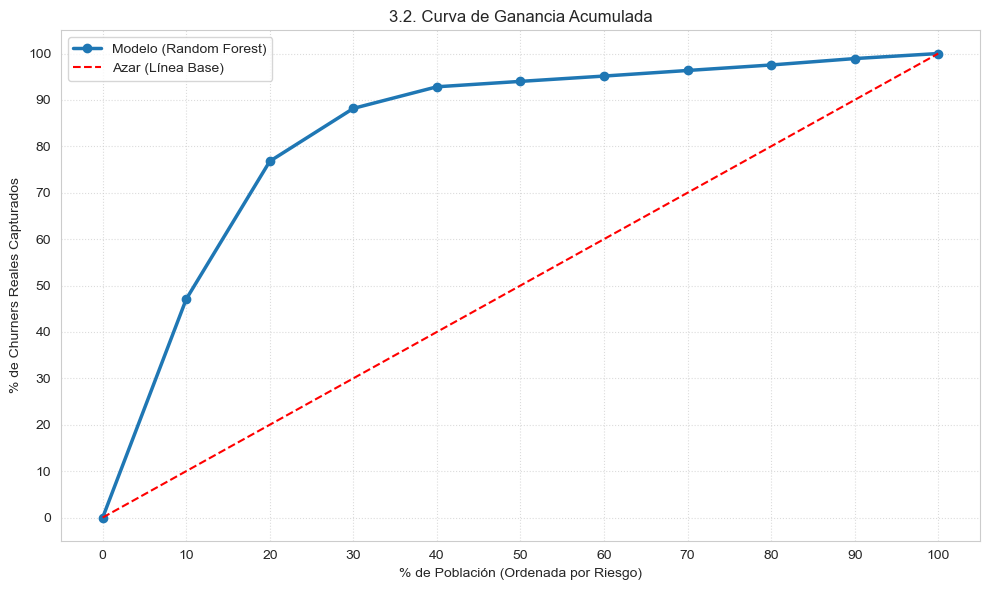

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Carga de datos
df = pd.read_csv('data_churn.csv')
X = df.drop('churn_real', axis=1)
y = df['churn_real']

# 2. División de datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==========================================
# 3.1. Entrenamiento e Importancia de Variables
# ==========================================
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Cálculo de importancia
importancias = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Gráfico de Importancia (Corregido para evitar el Warning)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancias, hue='Feature', palette='viridis', legend=False)
plt.title('3.1. Importancia de las Variables en la Predicción de Churn')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("=== 3.1. REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, model.predict(X_test)))

# ==========================================
# 3.2. Análisis de Lift y Ganancia (10 Deciles)
# ==========================================
y_probs = model.predict_proba(X_test)[:, 1]
lift_df = pd.DataFrame({'Actual': y_test, 'Probabilidad': y_probs})
lift_df = lift_df.sort_values(by='Probabilidad', ascending=False).reset_index(drop=True)

# Creación de 10 deciles
lift_df['Decil'] = pd.qcut(lift_df['Probabilidad'].rank(method='first'), 10, labels=False)
lift_df['Decil'] = 10 - lift_df['Decil']

# Métricas por decil
total_churners = lift_df['Actual'].sum()
tasa_global = lift_df['Actual'].mean()

resumen_lift = lift_df.groupby('Decil').agg(
    Clientes=('Actual', 'count'),
    Churners_Encontrados=('Actual', 'sum')
)

resumen_lift['Lift'] = (resumen_lift['Churners_Encontrados'] / resumen_lift['Clientes']) / tasa_global
resumen_lift['Ganancia_Acumulada_%'] = (resumen_lift['Churners_Encontrados'].cumsum() / total_churners) * 100

print("\n=== 3.2. TABLA DE LIFT Y GANANCIA (10 DECILES) ===")
print(resumen_lift[['Clientes', 'Churners_Encontrados', 'Lift', 'Ganancia_Acumulada_%']])

# Gráfico de Curva de Ganancia
plt.figure(figsize=(10, 6))
x_axis = np.arange(0, 110, 10)
y_axis = np.concatenate(([0], resumen_lift['Ganancia_Acumulada_%'].values))

plt.plot(x_axis, y_axis, marker='o', color='#1f77b4', linewidth=2.5, label='Modelo (Random Forest)')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Azar (Línea Base)')

plt.title('3.2. Curva de Ganancia Acumulada')
plt.xlabel('% de Población (Ordenada por Riesgo)')
plt.ylabel('% de Churners Reales Capturados')
plt.xticks(x_axis)
plt.yticks(np.arange(0, 110, 10))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()